In [1]:
!pip install timm

     |████████████████████████████████| 376 kB 279 kB/s 


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random
import timm
import torchvision
from torchvision import transforms
from tqdm import tqdm
import os
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2
import albumentations
import pickle


from sklearn.metrics import accuracy_score


warnings.filterwarnings("ignore")

In [3]:
seed = 2021
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(seed)

In [4]:
train_val_path = "../input/cov-dataset/train_data"

In [5]:
transform=transforms.Compose([
                              transforms.Resize([64,64]),
                              transforms.ToTensor()
])

In [6]:
dataset=ImageFolder(train_val_path,transform=transform)

In [7]:
img0,label0 = dataset[0]
print(img0.shape,label0)
img10,label10 = dataset[10]
print(img10.shape,label10)
print(dataset.classes)

torch.Size([3, 64, 64]) 0
torch.Size([3, 64, 64]) 0
['Covid', 'Normal']


label: 0


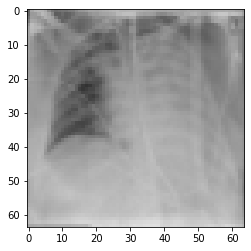

In [8]:
def show_img_with_label(img,label):
    print("label:" ,label)
    plt.imshow(img.permute(1,2,0))
    
show_img_with_label(img10,label10)

In [9]:
print(dataset.classes[0])
print(dataset.classes[1])
print(len(dataset))

Covid
Normal
2033


In [10]:
val_num= int(len(dataset)*0.3)
index = np.random.permutation(len(dataset))
val_idx = index[:val_num]
train_idx = index[val_num:]
print(val_idx[:5])

[1776  786 1726  711  282]


In [11]:
batch_size = 16

train_sampler = SubsetRandomSampler(train_idx)
train_df = DataLoader(dataset,batch_size = batch_size,sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_idx)
val_df = DataLoader(dataset,batch_size=batch_size,sampler = val_sampler)

In [12]:
class Model(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super(Model,self).__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)

    def forward(self, x):
        x = self.model(x)
        return x
    
model = Model('tf_efficientnet_b4_ns',2)

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)

Model(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_

In [14]:
loss_type = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


epoch:  0
508.8486472964287
epoch:  1
213.2916661798954
epoch:  2
61.43788407091051
epoch:  3
84.04784234333783
epoch:  4
32.317433243850246
epoch:  5
45.8226448581554
epoch:  6
14.67875645251479
epoch:  7
51.851511434535496
epoch:  8
4.165438146679662
epoch:  9
8.486355861998163
epoch:  10
33.88934015488485
epoch:  11
22.826920186693314
epoch:  12
8.718452113331296
epoch:  13
29.592213093303144
epoch:  14
3.5571436175087
epoch:  15
0.4878385566989891
epoch:  16
0.23686857415304985
epoch:  17
0.30557282295194454
epoch:  18
0.12521383720741142
epoch:  19
0.07805114667280577
epoch:  20
1.0606799047091044
epoch:  21
81.33458549836905
epoch:  22
47.20777271571569
epoch:  23
31.00532048617606
epoch:  24
17.34876532002818
epoch:  25
48.33630407048622
epoch:  26
88.66876728180796
epoch:  27
10.469850575667806
epoch:  28
0.6631402417697245
epoch:  29
0.1713631412712857
epoch:  30
0.11148217245499836
epoch:  31
0.1439721313690825
epoch:  32
0.12138350221357541
epoch:  33
0.08091712274836027
epo

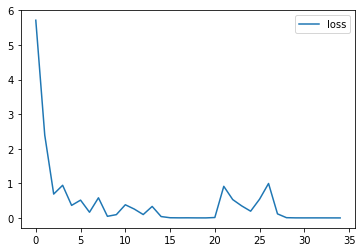

In [15]:
loss_val = []
for epoch in range(35):
    
    print("epoch: " , epoch)
    running_loss = 0
    for(i,data) in enumerate(train_df):
        img,label = data
        img,label = img.to(device),label.to(device)
        
        optimizer.zero_grad()
        
        output_label = model(img)
        
        loss = loss_type(output_label,label)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss = running_loss + loss.item()*img.size(0)
    
    loss_val.append(running_loss/len(train_df))
    
    print(running_loss)

plt.plot(loss_val,label="loss")
plt.legend()

# Validation Process

In [16]:
preds = []
labels = []

with torch.no_grad():
    for data in val_df:
        img,label = data
        img,label = img.to(device),label.to(device)
        
        output = model(img)
        _,predicted = torch.max(output,dim=1)
        
        
        preds.extend(predicted.cpu().detach().numpy())
        labels.extend(label.cpu().detach().numpy())
    
print("Accuracy: {}".format(accuracy_score(labels,preds)) )

Accuracy: 0.9901477832512315


In [17]:
model_path = "efficientnet_model.pkl"
with open(model_path,'wb') as f:
    pickle.dump(model,f)

# For test data

In [18]:
with open(model_path,'rb') as f:
    model = pickle.load(f)

In [19]:
test_dir = "../input/cov-dataset/test_data"

transform=transforms.Compose([
                              transforms.Resize([64,64]),
                              transforms.ToTensor()
])
test_data = ImageFolder(test_dir,transform = transform)

In [20]:
batch_size = 32

test_df = DataLoader(test_data,batch_size)

In [21]:
preds = []
labels = []

with torch.no_grad():
    for data in test_df:
        img,label = data
        img,label = img.to(device),label.to(device)
        output = model(img)
        _,predicted = torch.max(output,dim=1)
        
        preds.extend(predicted.cpu().detach().numpy())
        labels.extend(label.cpu().detach().numpy())
        
print(f"Accuracy for test data : {accuracy_score(preds,labels)}")

Accuracy for test data : 0.9133858267716536
